In [1]:
!pip install tifffile


In [2]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import nrrd

In [3]:
# Define the folder containing the images
current_directory = os.getcwd()
print(os.getcwd())

C:\Users\prana\Desktop\CV_Project


In [4]:
directory = current_directory + "\\tif\\"

Training Data:
Data shape: (165, 768, 1024)
Data type: uint8
Min and max values: 22, 244



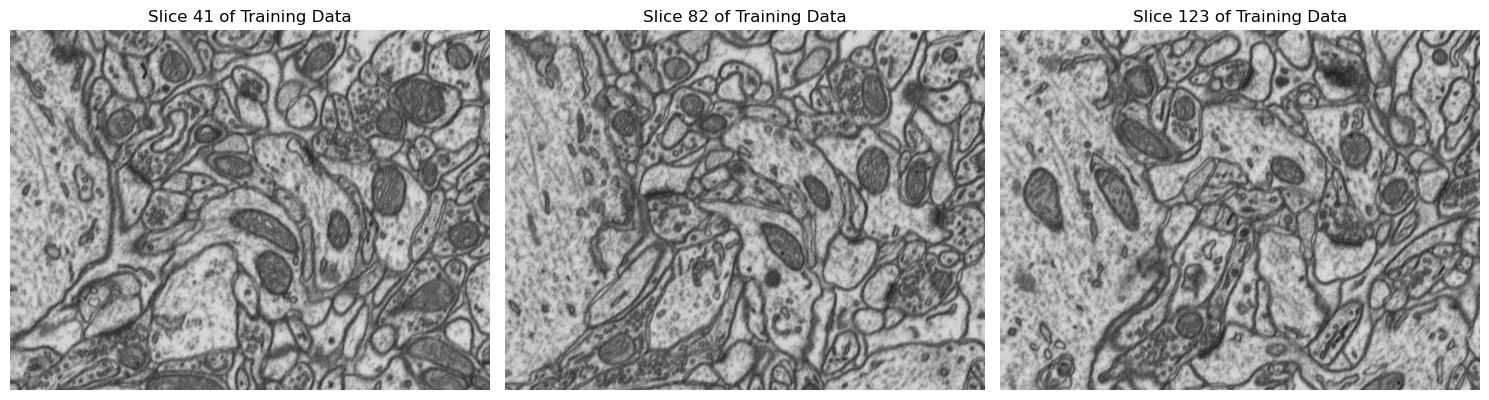

Training Groundtruth:
Data shape: (165, 768, 1024)
Data type: uint8
Min and max values: 0, 255



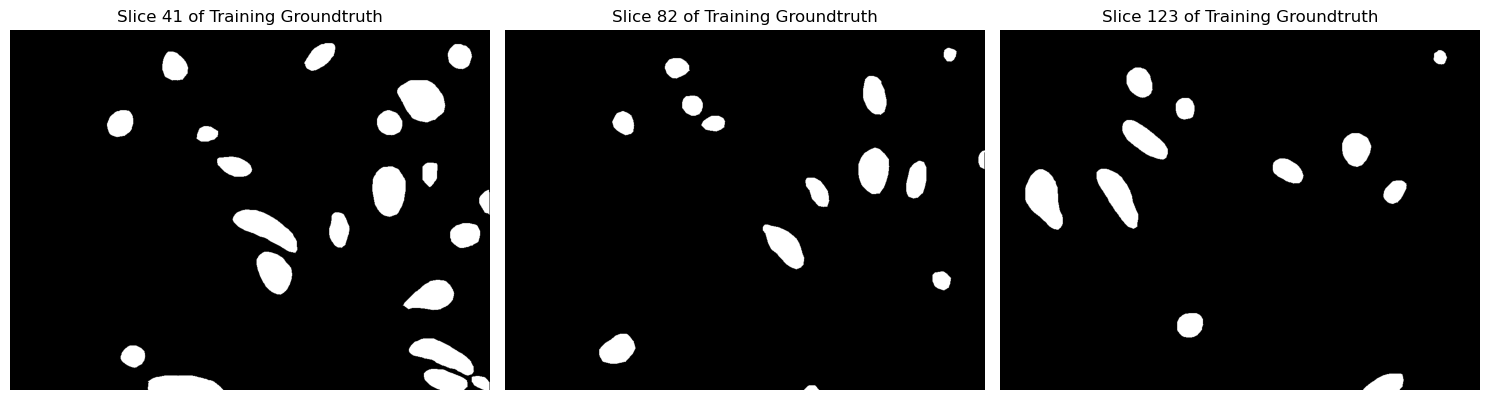

Testing Data:
Data shape: (165, 768, 1024)
Data type: uint8
Min and max values: 2, 255



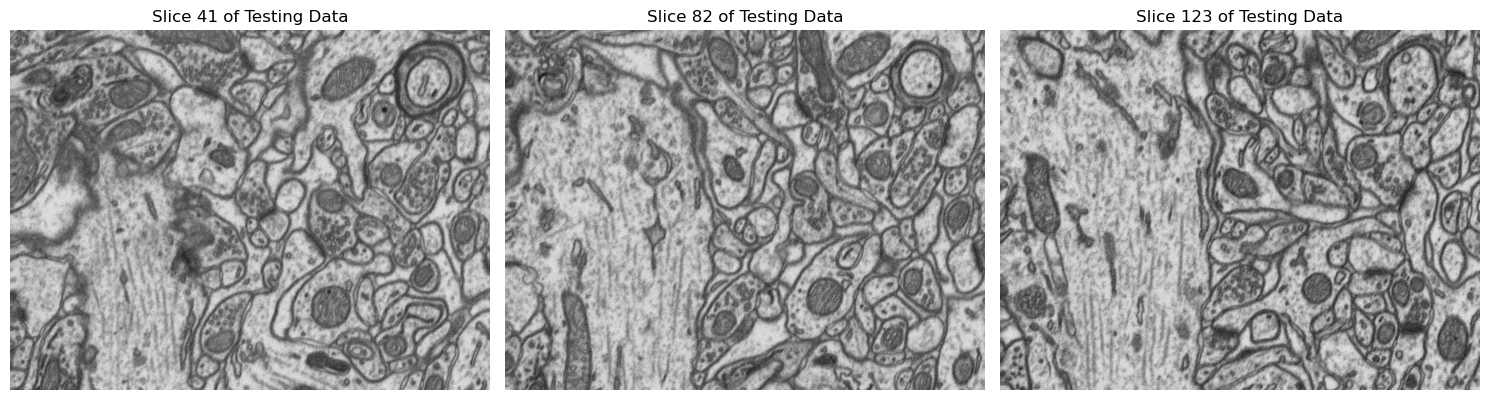

Testing Groundtruth:
Data shape: (165, 768, 1024)
Data type: uint8
Min and max values: 0, 255



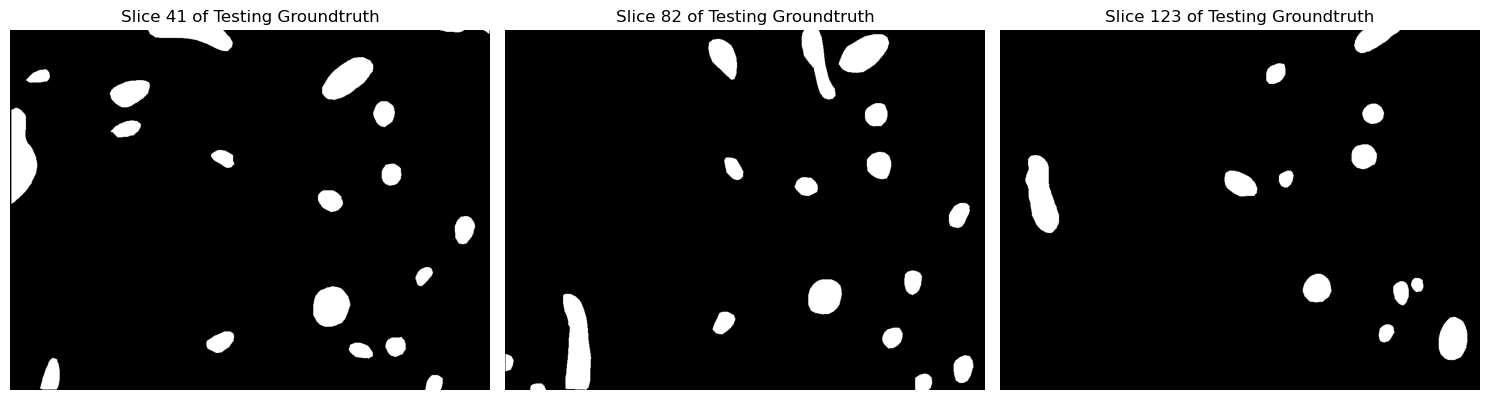

In [5]:
# Define the folder containing the images
current_directory = os.getcwd()
directory = current_directory + "\\tif\\" # replace with the path to your directory

# Load the files
train_data = tiff.imread(os.path.join(directory, 'training.tif'))
train_groundtruth = tiff.imread(os.path.join(directory, 'training_groundtruth.tif'))
test_data = tiff.imread(os.path.join(directory, 'testing.tif'))
test_groundtruth = tiff.imread(os.path.join(directory, 'testing_groundtruth.tif'))

datasets = {
    "Training Data": train_data,
    "Training Groundtruth": train_groundtruth,
    "Testing Data": test_data,
    "Testing Groundtruth": test_groundtruth
}

# Exploring and visualizing the datasets
for name, data in datasets.items():
    print(f"{name}:")
    print(f"Data shape: {data.shape}")
    print(f"Data type: {data.dtype}")
    print(f"Min and max values: {data.min()}, {data.max()}\n")

    # Visualize some slices
    num_slices = data.shape[0]
    sample_slices = [num_slices//4, num_slices//2, 3*num_slices//4]

    fig, axes = plt.subplots(1, len(sample_slices), figsize=(15, 5))
    for idx, slice_idx in enumerate(sample_slices):
        axes[idx].imshow(data[slice_idx, ...], cmap='gray')
        axes[idx].set_title(f'Slice {slice_idx} of {name}')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

In [6]:


# Load the files
train_data = tiff.imread(os.path.join(directory, 'training.tif'))
train_groundtruth = tiff.imread(os.path.join(directory, 'training_groundtruth.tif'))
test_data = tiff.imread(os.path.join(directory, 'testing.tif'))
test_groundtruth = tiff.imread(os.path.join(directory, 'testing_groundtruth.tif'))

# Resize function
def resize_data(data):
    resized_data = np.zeros((165, 500, 500), dtype=np.uint8)
    for i in range(165):
        resized_data[i] = resize(data[i], (500, 500), preserve_range=True).astype(np.uint8)
    return resized_data

# Resize the data
train_data_resized = resize_data(train_data)
train_groundtruth_resized = resize_data(train_groundtruth)
test_data_resized = resize_data(test_data)
test_groundtruth_resized = resize_data(test_groundtruth)



In [7]:
# Create directories to store resized images
resized_train_data_dir = os.path.join(directory, 'reTrain500')
resized_train_gt_dir = os.path.join(directory, 'reTrainGT500')
resized_test_data_dir = os.path.join(directory, 'reTest500')
resized_test_gt_dir = os.path.join(directory, 'reTestGT500')

os.makedirs(resized_train_data_dir, exist_ok=True)
os.makedirs(resized_train_gt_dir, exist_ok=True)
os.makedirs(resized_test_data_dir, exist_ok=True)
os.makedirs(resized_test_gt_dir, exist_ok=True)

# Save the resized data
for i in range(165):
    tiff.imsave(os.path.join(resized_train_data_dir, f'train_{i}.tif'), train_data_resized[i])
    tiff.imsave(os.path.join(resized_train_gt_dir, f'train_gt_{i}.tif'), train_groundtruth_resized[i])
    tiff.imsave(os.path.join(resized_test_data_dir, f'test_{i}.tif'), test_data_resized[i])
    tiff.imsave(os.path.join(resized_test_gt_dir, f'test_gt_{i}.tif'), test_groundtruth_resized[i])


**LOAD DATA HERE**

In [ ]:
# Load resized images from folders
def load_resized_data(data_dir, filename):
    data = np.zeros((165, 128, 128), dtype=np.uint8)
    for i in range(165):
        data[i] = tiff.imread(os.path.join(data_dir, f'{os.path.basename(filename)}_{i}.tif'))
    return data

print(directory)

resized_train_data = load_resized_data(directory + "reTrain", "train")
resized_train_groundtruth = load_resized_data(directory + "reTrainGT", "train_gt" )
resized_test_data = load_resized_data(directory + "reTest", "test")
resized_test_groundtruth = load_resized_data(directory + "reTestGT", "test_gt")


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2DTranspose,ZeroPadding2D,Conv2D,Add,Dropout,Input,UpSampling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img,img_to_array,plot_model 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint,EarlyStopping,Callback

In [3]:
def decoder_block(input,skip_features, num_filters,conv_padding=False,zero_pad=False):

    x= Conv2DTranspose(num_filters, 2, activation = 'relu',strides=(2,2), kernel_initializer = 'he_normal')(input)

    if zero_pad == True:
      x=ZeroPadding2D((1,1))(x)
    
    if conv_padding ==True:
        x=Conv2D(num_filters, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(x)
    else:
        x=Conv2D(num_filters, 2, activation = 'relu', kernel_initializer = 'he_normal')(x)
    
    x = Add()([x, skip_features])
    return x

In [4]:
def Unet_VGG19(input_size,n_classes):
    """ Input """
    inp = Input(input_size)
    """ Pre-trained Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inp)
    """ Encoder """
    E0=vgg19.get_layer("block1_conv2").output
    E0=Conv2D(128, 3, activation = 'relu', padding='same')(E0)
    E0=Conv2D(64, 3, activation = 'relu', padding='same')(E0)
    
    
    
    
    E1=vgg19.get_layer("block1_pool").output
    E1=Conv2D(128, 3, activation = 'relu', padding='same')(E1)
    E1=Conv2D(64, 3, activation = 'relu', padding='same')(E1)
    
    
    E2=vgg19.get_layer("block2_pool").output
    E2=Conv2D(128, 3, activation = 'relu', padding='same')(E2)
    
    
    E3=vgg19.get_layer("block3_pool").output
    E3=Conv2D(512, 3, activation = 'relu', padding='same')(E3)
    E3=Conv2D(256, 3, activation = 'relu', padding='same')(E3)
    
    
    E4=vgg19.get_layer("block4_pool").output
    E4=Conv2D(1024, 3, activation = 'relu', padding='same')(E4)
    E4=Conv2D(512, 3, activation = 'relu', padding='same')(E4)
    
    
    """ Bridge """
    B1=vgg19.get_layer("block5_pool").output
    B1=Conv2D(1024, 3, activation = 'relu', padding='same')(B1)
    
    """ Decoder """
    D1=decoder_block(B1,E4,512,zero_pad=True)
    
    
    D2=decoder_block(D1,E3,256,conv_padding=True)

    D3=decoder_block(D2,E2,128,zero_pad=True)

    D4=decoder_block(D3,E1,64,conv_padding=True)
    
    D5=decoder_block(D4,E0,64,conv_padding=True)

    """ Output """
    outputs=Conv2D(n_classes, 1, activation = 'sigmoid', padding = 'same')(D5)
    model = Model(inp,outputs, name="VGG19_U-Net")
    model.compile(optimizer = Adam(learning_rate = 1e-4), loss ='binary_crossentropy', metrics = ['accuracy' , tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1],threshold=0.6,name="IOU")])
    model.summary()
    return model

In [8]:
model=Unet_VGG19(input_size=(500,500,3),n_classes=1)

Model: "VGG19_U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 500, 500, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 500, 500, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 500, 500, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 250, 250, 64)         0         ['block1_conv2[0][0]']        
                                                                                        

                                                                                                  
 conv2d_15 (Conv2D)          (None, 125, 125, 128)        147584    ['block2_pool[0][0]']         
                                                                                                  
 add_3 (Add)                 (None, 125, 125, 128)        0         ['conv2d_23[0][0]',           
                                                                     'conv2d_15[0][0]']           
                                                                                                  
 conv2d_transpose_4 (Conv2D  (None, 250, 250, 64)         32832     ['add_3[0][0]']               
 Transpose)                                                                                       
                                                                                                  
 conv2d_13 (Conv2D)          (None, 250, 250, 128)        73856     ['block1_pool[0][0]']         
          

In [11]:
!pip install pydot
!pip install graphviz


     ---------------------------------------- 0.0/47.0 kB ? eta -:--:--
     ---------------------------------------- 47.0/47.0 kB ? eta 0:00:00
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:

plot_model(model,show_shapes=True,show_layer_names=True,expand_nested=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [19]:
#for training data:
train_path= directory + "/Train"
val_path= directory + "/Val"

image_datagen = ImageDataGenerator(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    rescale=1/255.)
mask_datagen = ImageDataGenerator(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    rescale=1/255.)


In [20]:
B_size=8
seed = 1
image_generator = image_datagen.flow_from_directory(
    train_path,
    class_mode=None,
    classes=['images'],
    color_mode='rgb',
    seed=seed,
    batch_size=B_size,
    target_size=(500,500))

mask_generator = mask_datagen.flow_from_directory(
    train_path,
    classes=['masks'],
    color_mode='grayscale',
    class_mode=None,
    seed=seed,
    batch_size=B_size,
    target_size=(500,500))
# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

def train_generator_fn():

    for (img,mask) in train_generator:
        yield (img,mask)

Found 165 images belonging to 1 classes.
Found 165 images belonging to 1 classes.


In [21]:
#for validation:

image_datagen = ImageDataGenerator(rescale=1/255.)
mask_datagen = ImageDataGenerator(rescale=1/255.)
B_size=8
seed = 1
image_generator = image_datagen.flow_from_directory(
    val_path,
    class_mode=None,
    classes=['images'],
    color_mode='rgb',
    seed=seed,
    batch_size=B_size,
    target_size=(500,500))

mask_generator = mask_datagen.flow_from_directory(
    val_path,
    classes=['masks'],
    color_mode='grayscale',
    class_mode=None,
    seed=seed,
    batch_size=B_size,
    target_size=(500,500))
# combine generators into one which yields image and masks
val_generator = zip(image_generator, mask_generator)

def val_generator_fn():

    for (img,mask) in val_generator:
        yield (img,mask)

Found 165 images belonging to 1 classes.
Found 165 images belonging to 1 classes.


In [23]:
#CallBacks and Model Fitting:
model_checkpoint = ModelCheckpoint('CheckPoint.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=4, min_lr=1e-8)
Earlystop=EarlyStopping(monitor="val_loss",patience=20,mode="auto",restore_best_weights=True)

epochs= 15
validation_steps= 4
with tf.device('/gpu:0'):
    model.fit(train_generator_fn(),
                        validation_data=val_generator_fn(),
                        steps_per_epoch=50,
                        validation_steps=validation_steps,
                        epochs=epochs,
                        callbacks=[model_checkpoint,reduce_lr,Earlystop]
              )

Epoch 1/15
15/15 [==============================] - ETA: 0s - loss: 0.3302 - accuracy: 0.9283 - IOU: 0.4796 
Epoch 1: val_loss improved from inf to 0.36250, saving model to CheckPoint.hdf5


C:\Users\prana\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - 844s 54s/step - loss: 0.3302 - accuracy: 0.9283 - IOU: 0.4796 - val_loss: 0.3625 - val_accuracy: 0.9383 - val_IOU: 0.4768 - lr: 1.0000e-04
Epoch 2/15
15/15 [==============================] - ETA: 0s - loss: 0.2523 - accuracy: 0.9343 - IOU: 0.4806  
Epoch 2: val_loss improved from 0.36250 to 0.22512, saving model to CheckPoint.hdf5
15/15 [==============================] - 4173s 296s/step - loss: 0.2523 - accuracy: 0.9343 - IOU: 0.4806 - val_loss: 0.2251 - val_accuracy: 0.9402 - val_IOU: 0.4776 - lr: 1.0000e-04
Epoch 3/15
15/15 [==============================] - ETA: 0s - loss: 0.1981 - accuracy: 0.9347 - IOU: 0.4807 
Epoch 3: val_loss did not improve from 0.22512
15/15 [==============================] - 369s 24s/step - loss: 0.1981 - accuracy: 0.9347 - IOU: 0.4807 - val_loss: 0.2320 - val_accuracy: 0.9368 - val_IOU: 0.4762 - lr: 1.0000e-04
Epoch 4/15
15/15 [==============================] - ETA: 0s - loss: 0.1762 - accuracy: 0.9359 - IOU: 0.4810 

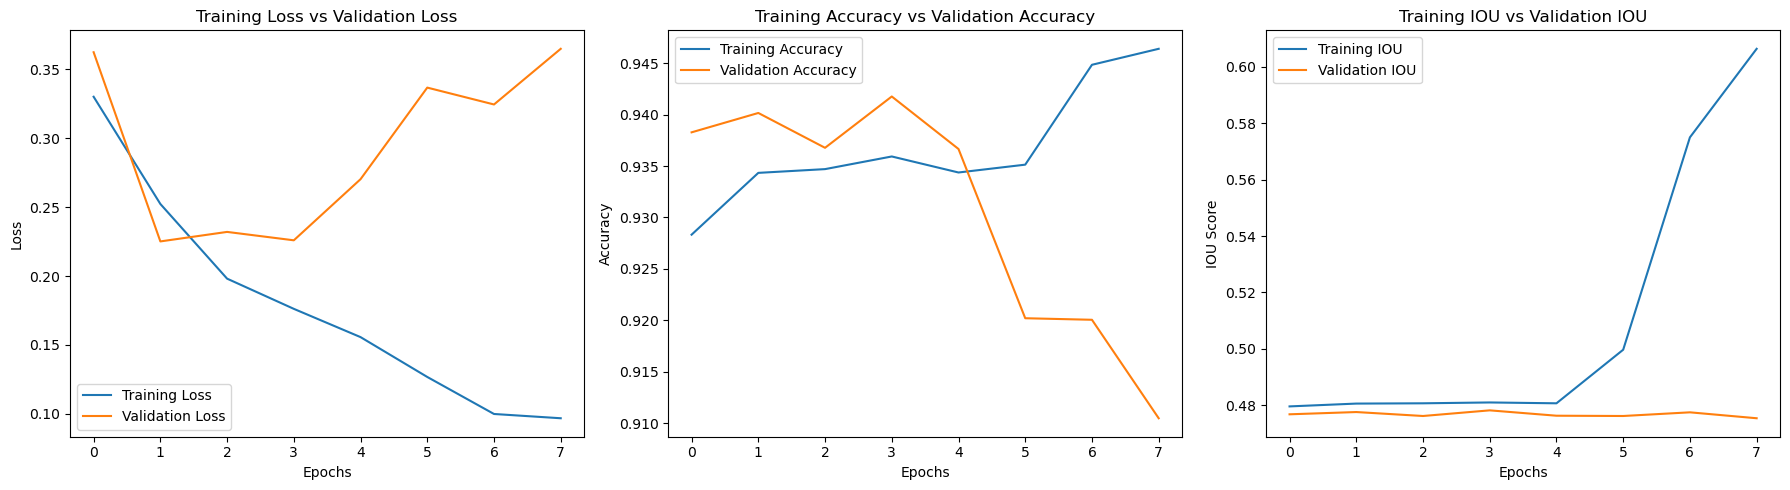

In [28]:
import matplotlib.pyplot as plt

iou_score = [0.4796, 0.4806, 0.4807, 0.4810, 0.4807, 0.4997, 0.5750, 0.6064]
val_iou_score = [0.4768, 0.4776, 0.4762, 0.4782, 0.4763, 0.4762, 0.4775, 0.4754]

# Extract the history from the model training output
history = model.history.history

# Setting up the plotting environment
plt.figure(figsize=(18, 5))

# Plotting the Training Loss vs Validation Loss
plt.subplot(1, 3, 1)
plt.plot(history['loss'][:15], label='Training Loss')
plt.plot(history['val_loss'][:15], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()

# Plotting the Training Accuracy vs Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(history['accuracy'][:15], label='Training Accuracy')
plt.plot(history['val_accuracy'][:15], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.legend()

# Plotting the Training IOU vs Validation IOU
plt.subplot(1, 3, 3)
plt.plot(iou_score, label='Training IOU')
plt.plot(val_iou_score, label='Validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU Score')
plt.title('Training IOU vs Validation IOU')
plt.legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 1s 1s/step


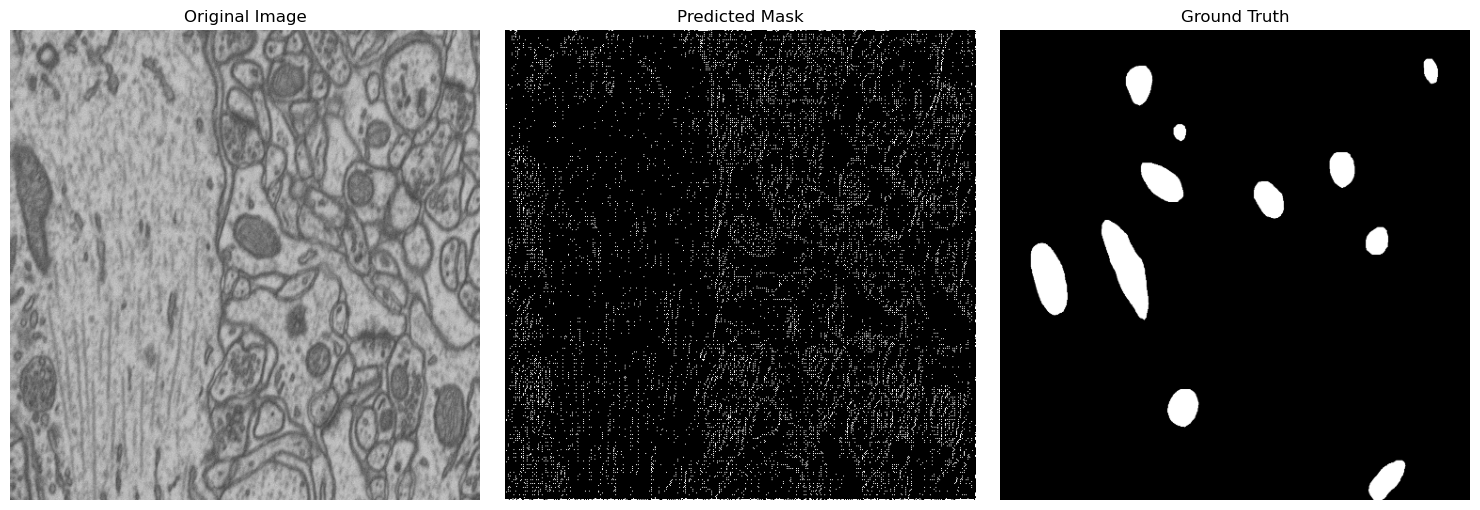

1/1 [==============================] - 1s 1s/step


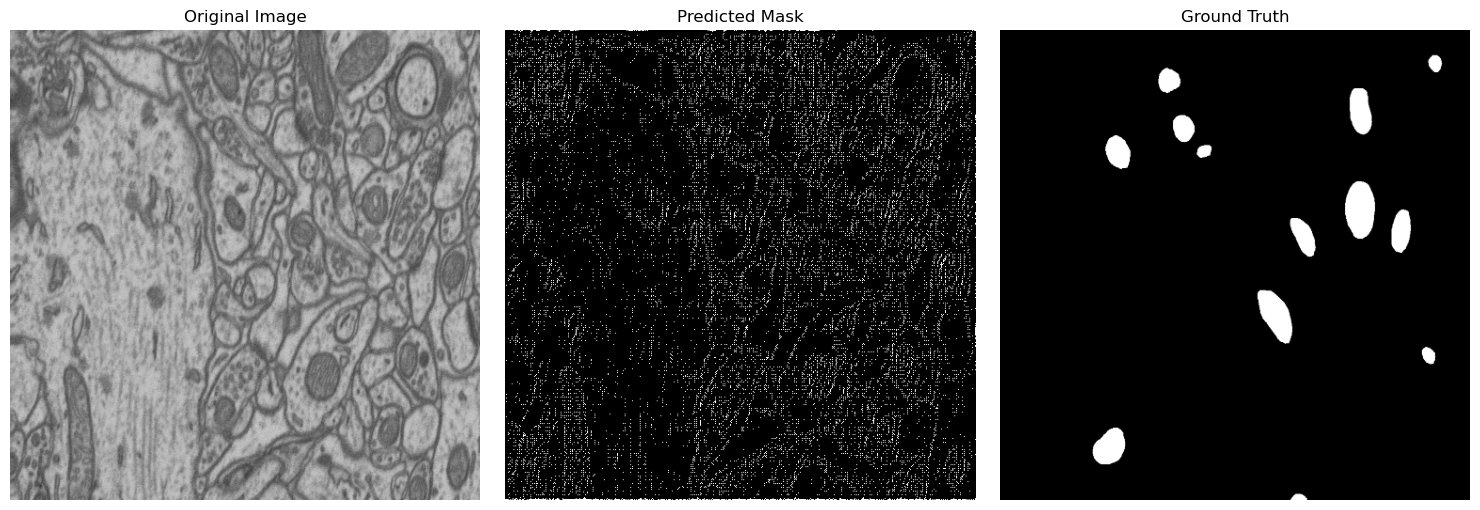

1/1 [==============================] - 1s 1s/step


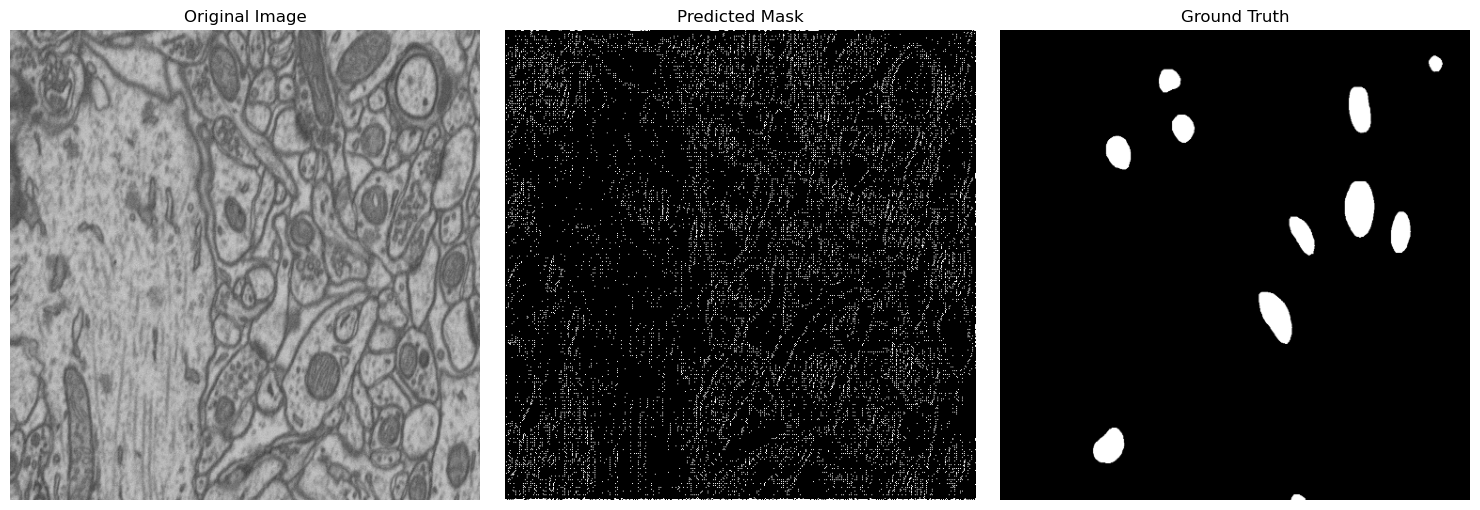

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Generate a batch of validation data
val_images, val_groundtruth = next(val_generator_fn())

# Randomly pick 2-3 indices from the batch of validation images
num_samples_to_show = random.choice([2, 3])
random_indices = random.sample(range(len(val_images)), num_samples_to_show)

for idx in random_indices:
    # Predicting on the sample image
    sample = np.expand_dims(val_images[idx], axis=0)  # Add batch dimension
    predicted_mask = model.predict(sample)
    predicted_mask = np.squeeze(predicted_mask, axis=(0, -1))  # Removing batch and channel dimensions

    # Threshold the prediction to get binary mask
    threshold = 0.15
    predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)

    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(val_images[idx], cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask_binary, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    # Ground Truth
    plt.subplot(1, 3, 3)
    plt.imshow(val_groundtruth[idx], cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
